# Surrogate modeling of 2D jet data using SPOD

In this tutorial we will explore a small dataset provided with this package that contains pressure data of the flow exiting a nozzle (also referred to as a jet). In particular, we want to identify whether the data contains spatio-temporal coherent structures. Following the identification of these modes, we will build a reduced-order model using time-series methods in machine learning.

## Loading and configuring data

The dataset is part of the data used for the regression tests that come with this library and is stored into `tests/data/fluidmechanic_data.mat`. The first step to anlyze this dataset is to import the required libraries, including the custom libraries 
- `from pyspod.spod_low_storage import SPOD_low_storage`
- `from pyspod.spod_low_ram     import SPOD_low_ram`

that contain two different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines). Note that the surrogate modeling strategy is currently incompatible with the streaming algorithm.

Note that we also import the custom library 
- `import library.weights as weights`

that implements the various weight matrices that might be required when performing SPOD. 

In [1]:
import os
import sys
import time
import h5py
import warnings
import xarray as xr
import numpy  as np
from pathlib import Path

# Paths
CWD = os.getcwd()
sys.path.append(os.path.join(CWD,"../../../"))

# Import library specific modules
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
import pyspod.weights as weights

We then need to load the data from the `.mat` file and inspect it:

In [2]:
# Inspect and load data 
file = os.path.join(CWD,'../../../tests/data/fluidmechanics_data.mat')
variables = ['p']
with h5py.File(file, 'r') as f:
	data_arrays = dict()
	for k, v in f.items():
		data_arrays[k] = np.array(v)
dt = data_arrays['dt'][0,0]
block_dimension = 64 * dt
x1 = data_arrays['r'].T; x1 = x1[:,0]
x2 = data_arrays['x'].T; x2 = x2[0,:]
X = data_arrays[variables[0]].T
t = dt * np.arange(0,X.shape[0]); t = t.T

print('t.shape  = ', t.shape)
print('x1.shape = ', x1.shape)
print('x2.shape = ', x2.shape)
print('X.shape  = ', X.shape)

t.shape  =  (1000,)
x1.shape =  (20,)
x2.shape =  (88,)
X.shape  =  (1000, 20, 88)


the `mat` file contains **3 coordinates**:
- r, (radial coordinate)
- x, (axial coordinate) 
- time, 

along with **1 variable**:

- p (pressure).

In order for the data matrix `X` to be suitable to the `PySPOD` library the
- first dimension must correspond to the number of time snapshots (1000 in our case)
- last dimension should corresponds to the number of variables (1 in our case)
- the remaining dimensions corresponds to the spatial dimensions (20, and 88 in our case, that correspond to radial and axial spatial coordinates).

We note that the data matrix `X` used is already in a shape that is suitable to `PySPOD`, as its dimension is:

$$\text{$X$ dimensions} = 1000 \times 20 \times 88 $$

It is important to note at this point that we loaded all the required data into RAM, and stored it into a `numpy.ndarray`. We will later pass this array to the constructor of the `PySPOD` class for running our analysis. However, we could have used a different approach to load the data. In fact, the constructor to the `PySPOD` class accepts an argument called `data_handler`, that points to a function whose objective is to read the data at run time. This is particularly useful for large datasets, where it might be not possible to load all the data in RAM upfront. Therefore, in this case, we could simply define a data reader function as the following:

```
def read_data(data, t_0, t_end, variables): 
    ... implement here your method
    data: path to the data file
    t_0: start time slicing
    t_end: end time slicing
    variables: list with names of the variables

    return X
```

and pass it to the `PySPOD` constructor under the argument `data_handler`. The path to the data file, will then be specified in place of the data, under the argument `X`. See below, when we setup the analysis and call the constructor for a more detailed explantion of the parameters `X` and `data_handler`. In summary, if `X` is a numpy.ndarray containing your data, `data_handler` is set to `False`, if `X` is a `str` containing the path to your data file, `data_handler` is a function that reads your data, and whose arguments must be: (1.) `str` containing the path to the data file, (2) `int` containing the start time snapshot for slicing the data sequentially at run time, (3) `int` containing the end time snapshot for slicing the data sequentially at run time, and (4) a `list` containing the name of the variables in your data file. 

## Setting required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `dt`: time-sampling of the data (for now this must be constant)
- `nt`: number of time snapshots
- `xdim`: number of spatial dimensions
- `nv`: number of variables
- `n_FFT`: length of FFT blocks
- `n_freq`: number of frequencies
- `n_overlap`: dimension of the overlap region between adjacent blocks
- `mean`: type of mean to be subtracted from the data
- `normalize`: data normalization by data variance
- `savedir`: where to save the data
- `weights`: weights to be used to compute the inner product

The optional parameters are as follows:
- `savefreqs`: number of frequencies to be saved
- `n_modes_save`: number of modes to be saved
- `normavar`: normalize data by variance
- `conf_level`: calculate confidence level of modes
- `savefft`: save FFT blocks to reuse them in the future (to save time)


<font color='green'> **Note: we set the weights equal to a vector of ones, that must have the dimension of the flattened array along the spatial axes multiplied by the number of variables, that is:**
    
$$\textsf{weights dim} = \textsf{number of spatial points} \times \textsf{number of variables}$$. </font>

### Important: Ensure `params['savefft'] = True` for training surrogate model

In [3]:
# define required and optional parameters
params = dict()

# required parameters
overlap_in_percent = 50
params['dt'          ] = dt              # data time-sampling
params['nt'          ] = t.shape[0]      # number of time snapshots
params['xdim'        ] = 2               # number of spatial dimensions 
params['nv'          ] = len(variables)  # number of variables
params['n_FFT'       ] = np.ceil(block_dimension / dt)     # length of FFT blocks
params['n_freq'      ] = params['n_FFT'] / 2 + 1           # number of frequencies 
params['n_overlap'   ] = np.ceil(params['n_FFT'] * overlap_in_percent / 100) # dimension block overlap region
params['mean'        ] = 'blockwise'  # type of mean to subtract to the data
params['normalize'   ] = False        # normalization of weights by data variance 
params['savedir'     ] = os.path.join(CWD, 'results', Path(file).stem) # folder where to save results
params['weights'] = np.ones([x1.shape[0]*x2.shape[0]*params['nv']])

# optional parameters
params['savefreqs'   ] = np.arange(0,params['n_freq']) # frequencies to be saved
params['n_modes_save'] = 3      # modes to be saved (dimensionality of emulator)
params['normvar'     ] = False  # normalize data by data variance
params['conf_level'  ] = 0.95   # calculate confidence level
params['savefft'     ] = True  # save FFT blocks to reuse them in the future (saves time)

## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_streaming(X=X, params=params, data_handler=False, variables=variables)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes `X`, that can either be a `numpy.ndarray` containing the data or the path to the data file , the parameters `params`, a parameter called `data_handler` that can be either `False` or a function to read the data, and `variables` that is the list containing the names of our variables. If, as `data_handler`, we pass `False`, then we need to load the entire matrix of data into RAM, and that must comply with the **PySPOD** input data requirements (i.e. the dimension of the data matrix must correspond to (time $\times$ spatial dimension shape $\times$ number of variables). 

In more detail, the arguments to the constructor are defined as follows:

  - `X`: it can either be a `numpy.ndarray` and contain all data required for the analysis or a `str` containing the path to the data file. If we pass a `numpy.ndarray`, its dimensions must be equal to (time $\times$ spatial dimension shape $\times$ number of variables), and the argument `file_handler` must be set to `False`. If we pass a `str` containing the path to the data file, we need also to provide a data reader through the argument `data_handler`. The data reader must conform to reading the file and storing the data in memory according to the shape of data just described: **(number of time snapshots $\times$ shape of spatial dimensions $\times$ number of variables)**. Note that the template for the data reader must have as first argument the path to the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. An example of data reader was provided above. You can readily modify it according to your needs. See the sections above for a template example of the data reader function.
  - `params`: must be a dictionary and contains the parameters that we have just defined. 
  - `data_handler`: can be either `False` or a function handler. If it is a function handler, it must hold the function to read the data. The template for the function to read the data must have as first argument the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. See hour data reader as an example and modify it according to your needs.
  - `variables`: is a list containing our variables. 

The `fit()` method returns a `PySPOD` object containg the results. 

In [4]:
# Perform SPOD analysis using low RAM module
SPOD_analysis = SPOD_low_storage(X=X, params=params, data_handler=False, variables=variables)
spod = SPOD_analysis.fit()


SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block :  64
Block overlap             :  32
No. of blocks             :  30
Windowing fct. (time)     :  hamming
Weighting fct. (space)    :  user-specified
Mean                      :  blockwise
Time-step                 :  0.2
Number of Frequencies     :  33
------------------------------------

DATA MATRIX DIMENSIONS
------------------------------------
Problem size          :  0.013113021850585958 GB. (double)
data matrix dimensions:         (1, 20, 88, 1)
Make sure that first column of data matrix is time and last column is number of variables. 
First column dimension: 1 must correspond to number of time snapshots.
Last column dimension: 1 must correspond to number of variables.
------------------------------------
 
Calculating temporal DFT (low_storage)
--------------------------------------
RAM available =  6.988655090332042
RAM required  =  0.003

computing frequencies:  48%|████▊     | 16/33 [00:00<00:00, 151.02it/s]

--------------------------------------
 
Calculating SPOD (low_storage)
--------------------------------------


computing frequencies: 100%|██████████| 33/33 [00:00<00:00, 120.77it/s]

--------------------------------------
 
Results saved in folder  /home/rmlans/Desktop/PySPOD/tutorials/emulation/jet_2D/results/fluidmechanics_data/nfft64_novlp32_nblks30
Elapsed time:  0.7430601119995117 s.


## Postprocessing and visualizing results

The results are stored in a `PySPOD` objcet that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first select the frequency (equivalently period T_approx), that we want to investigate, and identify the nearest frequency in the results by using the built-in functions `find_nearest_freq`, and `get_modes_at_freq`, that are part of the `postprocessing` module, and can be directly called from the `PySPOD` object returned once the `fit` method has completed.

In [5]:
# Show results
T_approx = 12.5 # approximate period
freq_found, freq_idx = spod.find_nearest_freq(freq_required=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

- RAM required for loading all modes ~ 0.0001573562622070315 GB
- Available RAM memory               ~ 6.984027862548839 GB


We can then plot the **eigenvalues in the complex plane**, using the built-in function `plot_eigs`, that is part of the `postprocessing` module. We note that the eigenvalues are all real.

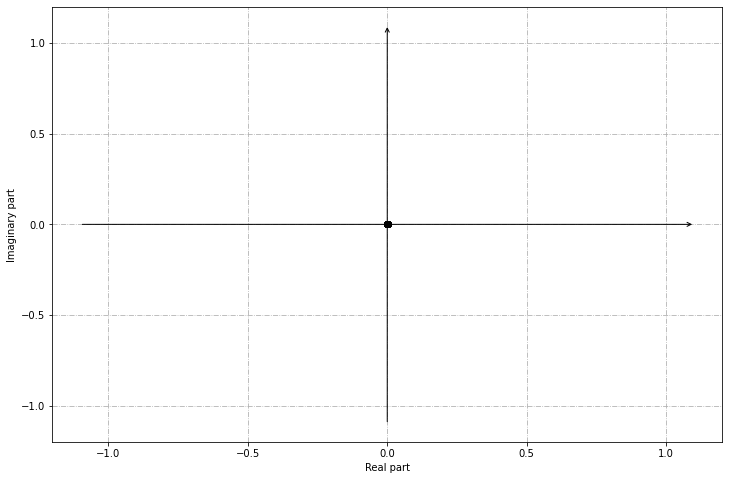

In [6]:
spod.plot_eigs()

We can then plot the **eigenvalues as a function of frequency and period**. Again, we can see how thorough the `PySPOD` object returned after the computation we can access the frequency array (`spod.freq`) along with the plotting methods `spod.plot_eigs_vs_frequency` and `spod.plot_eigs_vs_period`.

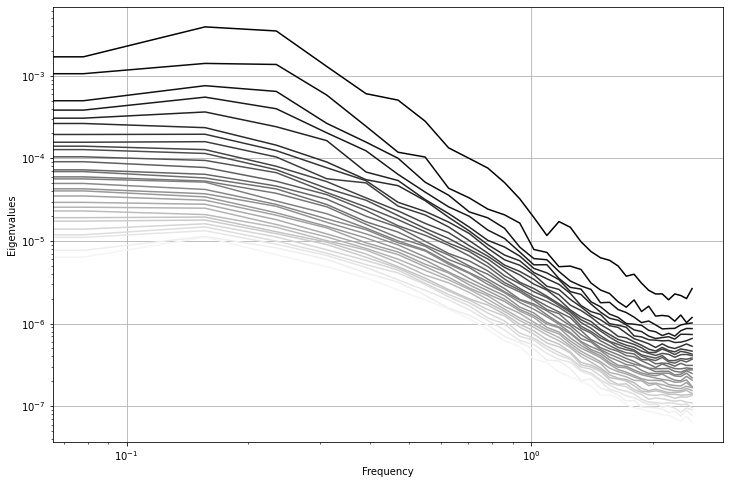

In [7]:
freq = spod.freq
spod.plot_eigs_vs_frequency(freq=freq)

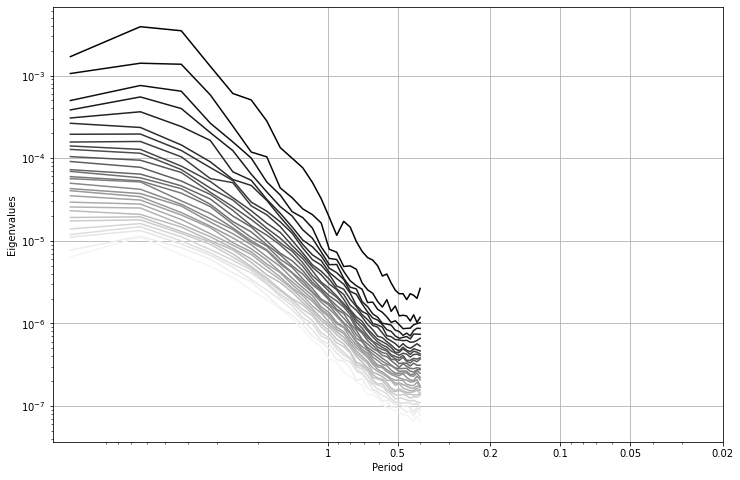

In [8]:
spod.plot_eigs_vs_period   (freq=freq, xticks=[1, 0.5, 0.2, 0.1, 0.05, 0.02])

We can then plot the **modes** that were computed by the SPOD algorithm via the built-in `plot_2D_modes_at_frequency` method, that can again be accessed via the `PySPOD` object returned after the computation. To this method, we pass the frequency of the modes we are interested in. This corresponds to the frequency associated to the T_approx of 12.5 time units that we requested, and stored in the variable `freq_found` that we calculated above. Note that we also pass the `vars_idx` corresponding to the variable we are interested in, modes_idx corresponding to the modes we are interested in, as well as `x1`, and `x2`, that correspond to radial and axial coordinates. 

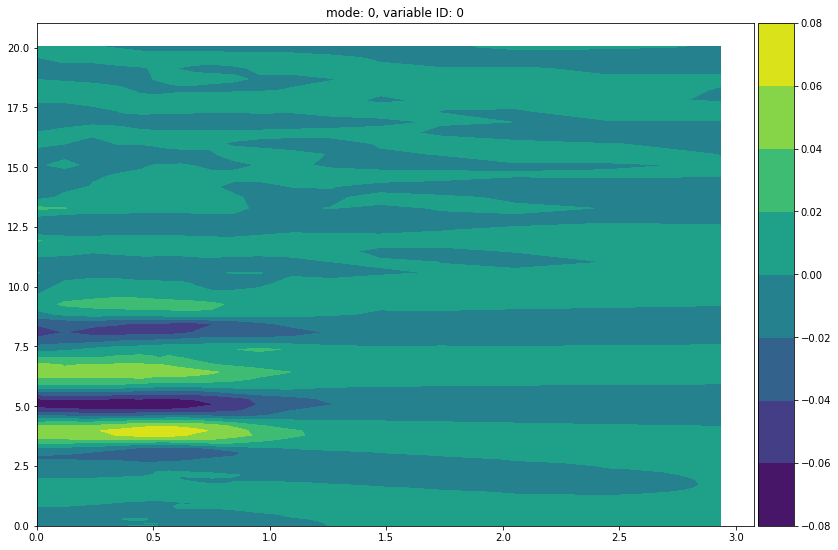

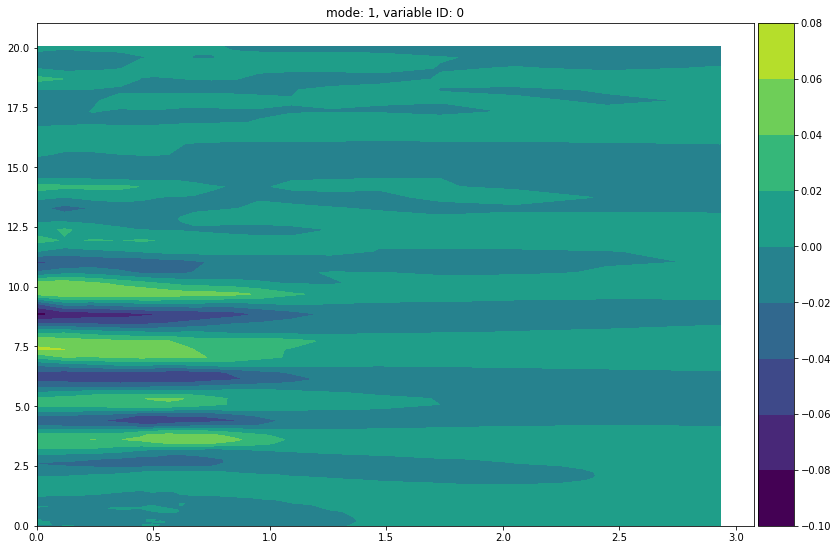

In [9]:
spod.plot_2D_modes_at_frequency(
	freq_required=freq_found, 
    freq=freq, 
    x1=x1, 
    x2=x2, 
    modes_idx=[0,1], 
    vars_idx=[0])

Note that we can also plot the **original data** by

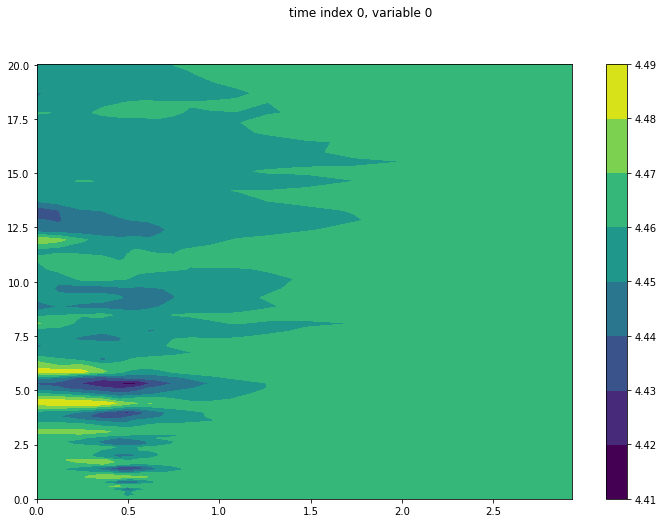

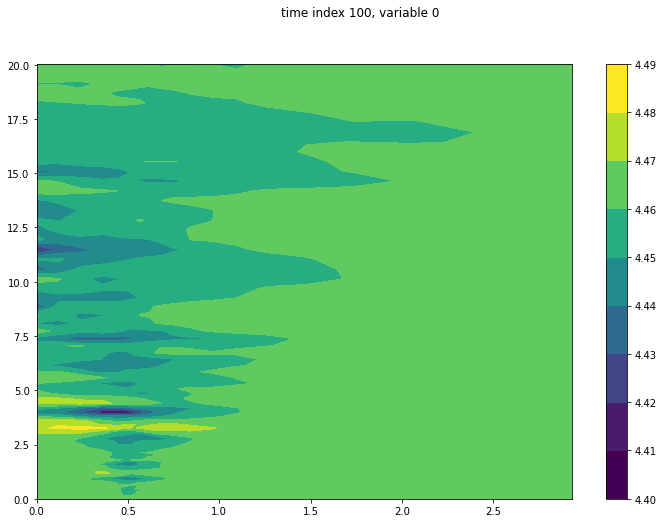

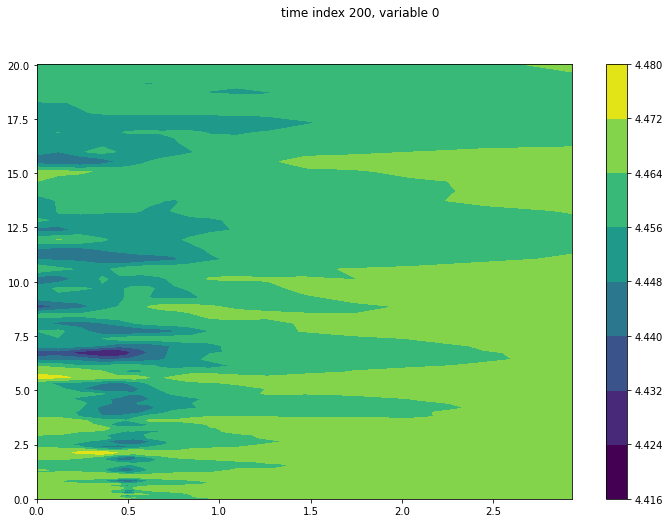

In [10]:
spod.plot_2D_data(x1=x1, x2=x2, vars_idx=[0], time_idx=[0,100,200])

Along with a video of the original data

In [11]:
spod.generate_2D_data_video(x1=x1, x2=x2, vars_idx=[0])

## Now we are ready to build a surrogate model using the SPOD modes

First we need to generate the training data. This is obtained by loading the previously saved SPOD modes and Fourier-transformed data to obtain the coefficients that must be emulated by a deep learning model. See Section 2c of Spectral Empirical Orthogonal Function Analysis of Weather and Climate Data by Schmidt et al., 2019

In [12]:
spod.get_coefficients()

computing coefficients: 100%|██████████| 33/33 [00:00<00:00, 51.94it/s]


In [13]:
spod.build_emulator()

loading coefficients: 100%|██████████| 33/33 [00:00<00:00, 2300.54it/s]


Model: "Emulation_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_inputs (InputLayer)     [(None, 33, 3)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 33, 50)            10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 50)            20200     
_________________________________________________________________
dense (Dense)                (None, 33, 3)             153       
Total params: 31,153
Trainable params: 31,153
Non-trainable params: 0
_________________________________________________________________


In [14]:
spod.fit_emulator(batch_size=4,num_epochs=300)

Epoch 1/300
6/6 [==============================] - 0s 29ms/step - loss: 8.8603e-06 - coeff_determination: -225.9257
Epoch 2/300
6/6 [==============================] - 0s 29ms/step - loss: 8.7646e-06 - coeff_determination: -234.6057
Epoch 3/300
6/6 [==============================] - 0s 45ms/step - loss: 8.7796e-06 - coeff_determination: -246.4468
Epoch 4/300
6/6 [==============================] - 0s 58ms/step - loss: 8.7612e-06 - coeff_determination: -237.3928
Epoch 5/300
6/6 [==============================] - 0s 54ms/step - loss: 8.7712e-06 - coeff_determination: -231.6465
Epoch 6/300
6/6 [==============================] - 0s 55ms/step - loss: 8.7790e-06 - coeff_determination: -232.0130
Epoch 7/300
6/6 [==============================] - 0s 56ms/step - loss: 8.7661e-06 - coeff_determination: -242.0661
Epoch 8/300
6/6 [==============================] - 0s 70ms/step - loss: 8.7347e-06 - coeff_determination: -247.0183
Epoch 9/300
6/6 [==============================] - 0s 65ms/step - loss: 

In [15]:
spod.test_emulator()

computing predicted coefficients: 100%|██████████| 33/33 [00:00<00:00, 690.53it/s]


In [16]:
spod.testing_data_pred.shape

(8, 33, 3)

## Final notes

The results are stored in the results folder defined in the parameter `params[savedir]` you specified. We can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.

This tutorial was intended to help you setup your own 2D case. You can play with the parameters we explored above to gain more insights into the capabilities of the library. You can also run on the same data the other two SPOD algorithms implemented as part of this library by simply calling:
- SPOD_analysis = SPOD_low_storage(X=X, params=params, file_handler=False)
- SPOD_analysis = SPOD_low_ram(X=X, params=params, file_handler=False)

and compare the results.